# Time Series Decomposition

This tutorial shows how to decompose AutoGP models into their constituent temporal components, to gain more insight into the learned time series structures.

The relevant method is [`AutoGP.decompose`](@ref).

In [1]:
import AutoGP

In [2]:
import CSV
import Dates
import DataFrames
import PyPlot

## Loading Data

In [3]:
AutoGP.seed!(10)

In [4]:
data = CSV.File("assets/M1266.csv")
M3 = DataFrames.DataFrame(data);
df = M3[:,["ds","y"]];

We next split the data into a training set and test set.

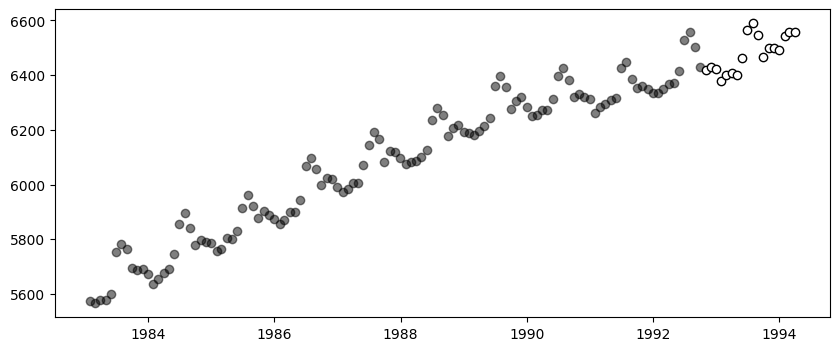

PyObject <matplotlib.collections.PathCollection object at 0x778f98059a60>

In [5]:
n_test = 18
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

fig, ax = PyPlot.subplots(figsize=(10,4))
ax.scatter(df_train.ds, df_train.y, marker="o", color="k", alpha=.5)
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Creating an AutoGP Model

In [6]:
model = AutoGP.GPModel(df_train.ds, df_train.y; n_particles=18);

In [7]:
ds_future = range(start=df.ds[end]+Dates.Month(1), step=Dates.Month(1), length=2*size(df_test)[1])
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

Let us visualize the forecasts before model fitting. The model clearly underfits the data.

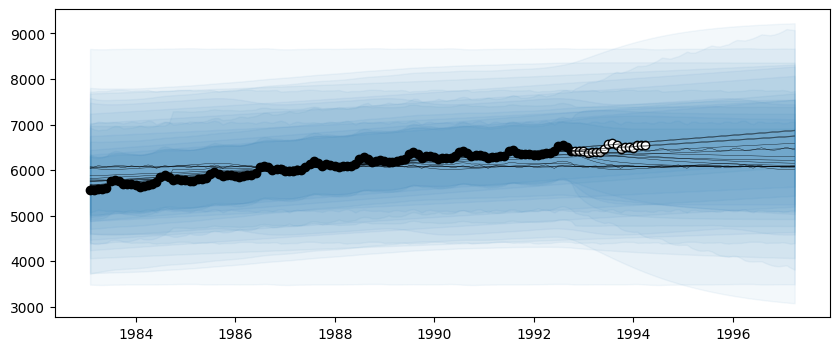

PyObject <matplotlib.collections.PathCollection object at 0x778f8f90a900>

In [8]:
fig, ax = PyPlot.subplots(figsize=(10,4))
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.25)
    ax.fill_between(subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"], color="tab:blue", alpha=0.05)
end
ax.scatter(df_train.ds, df_train.y, marker="o", color="k")
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Model Fitting via SMC

In [9]:
AutoGP.fit_smc!(model; schedule=AutoGP.Schedule.linear_schedule(n_train, .025), n_mcmc=50, n_hmc=25, verbose=false);
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

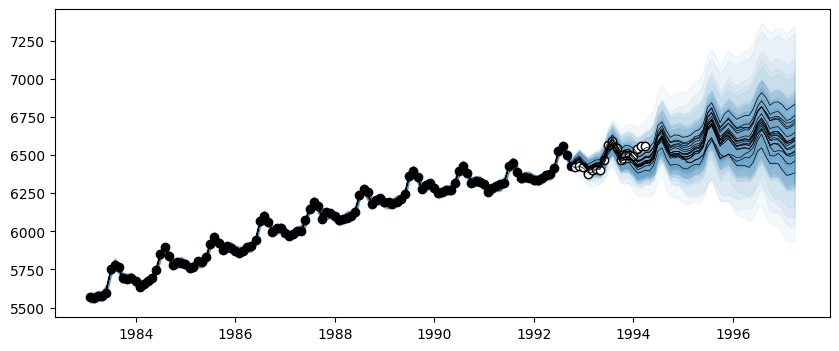

PyObject <matplotlib.collections.PathCollection object at 0x778f8d8175f0>

In [10]:
fig, ax = PyPlot.subplots(figsize=(10,4))
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end
ax.scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Decomposing into Constituent Kernels

In [11]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    display(k)
end

Model 1, Weight 0.1047078523238027


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── +
    │   ├── ×
    │   │   ├── ×
    │   │   │   ├── LIN(0.18; 0.41, 0.11)
    │   │   │   └── GE(0.16, 1.42; 0.07)
    │   │   └── LIN(0.44; 0.12, 0.05)
    │   └── +
    │       ├── ×
    │       │   ├── LIN(0.30; 0.20, 0.08)
    │       │   └── PER(0.23, 0.31; 0.05)
    │       └── LIN(0.26; 0.27, 0.23)
    └── LIN(0.09; 0.11, 0.79)


Model 2, Weight 0.0361298068161129


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── ×
    │   ├── ×
    │   │   ├── +
    │   │   │   ├── GE(0.49, 1.26; 0.18)
    │   │   │   └── LIN(0.52; 0.15, 0.22)
    │   │   └── LIN(0.74; 0.12, 0.17)
    │   └── GE(0.62, 0.98; 0.05)
    └── +
        ├── ×
        │   ├── LIN(0.89; 0.26, 0.10)
        │   └── PER(0.23, 0.31; 0.05)
        └── LIN(0.22; 0.14, 0.70)


Model 3, Weight 0.06115923536154616


×
├── LIN(0.17; 0.29, 0.04)
└── +
    ├── +
    │   ├── +
    │   │   ├── +
    │   │   │   ├── ×
    │   │   │   │   ├── LIN(0.08; 0.32, 0.53)
    │   │   │   │   └── LIN(0.60; 0.10, 0.13)
    │   │   │   └── ×
    │   │   │       ├── LIN(0.67; 0.03, 0.28)
    │   │   │       └── GE(0.19, 1.76; 0.06)
    │   │   └── +
    │   │       ├── ×
    │   │       │   ├── LIN(0.23; 0.20, 0.09)
    │   │       │   └── PER(0.18, 0.31; 0.04)
    │   │       └── LIN(1.02; 0.28, 0.33)
    │   └── LIN(0.08; 0.13, 0.61)
    └── LIN(0.11; 0.32, 0.24)


Model 4, Weight 0.05765497451892912


×
├── LIN(0.17; 0.29, 0.04)
└── +
    ├── ×
    │   ├── LIN(0.89; 0.01, 0.34)
    │   └── ×
    │       ├── GE(0.39, 1.69; 0.26)
    │       └── LIN(0.08; 0.03, 0.30)
    └── +
        ├── ×
        │   ├── LIN(0.23; 0.20, 0.09)
        │   └── +
        │       ├── PER(0.18, 0.31; 0.04)
        │       └── ×
        │           ├── LIN(0.10; 1.09, 0.18)
        │           └── LIN(0.58; 0.04, 0.13)
        └── +
            ├── LIN(0.23; 0.12, 1.30)
            └── LIN(0.44; 0.05, 0.23)


Model 5, Weight 0.08412270828154682


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── +
    │   ├── GE(0.24, 1.60; 0.01)
    │   └── ×
    │       ├── LIN(0.30; 0.20, 0.08)
    │       └── PER(0.23, 0.31; 0.05)
    └── +
        ├── LIN(0.11; 1.35, 0.26)
        └── LIN(0.17; 0.19, 0.26)


Model 6, Weight 0.0611062884120964


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── +
    │   ├── ×
    │   │   ├── GE(0.43, 1.56; 0.09)
    │   │   └── LIN(0.32; 0.25, 0.26)
    │   └── +
    │       ├── ×
    │       │   ├── LIN(0.30; 0.20, 0.08)
    │       │   └── PER(0.23, 0.31; 0.05)
    │       └── LIN(0.11; 0.17, 0.57)
    └── LIN(0.07; 0.06, 0.52)


Model 7, Weight 0.05012538373480415


×
├── LIN(0.06; 0.30, 0.06)
└── +
    ├── GE(0.76, 1.85; 0.23)
    └── ×
        ├── LIN(0.32; 0.20, 0.08)
        └── +
            ├── LIN(0.28; 0.26, 0.15)
            └── PER(0.29, 0.31; 0.07)


Model 8, Weight 0.0008966800224218749


×
├── GE(2.06, 1.54; 0.08)
└── +
    ├── +
    │   ├── LIN(0.58; 0.47, 0.45)
    │   └── LIN(0.41; 0.86, 0.11)
    └── PER(0.58, 0.21; 0.14)


Model 9, Weight 0.04677692738637331


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── +
    │   ├── ×
    │   │   ├── +
    │   │   │   ├── GE(0.24, 1.60; 0.01)
    │   │   │   └── LIN(0.23; 0.17, 0.67)
    │   │   └── LIN(1.05; 0.16, 0.25)
    │   └── ×
    │       ├── LIN(0.30; 0.20, 0.08)
    │       └── PER(0.23, 0.31; 0.05)
    └── LIN(0.60; 0.37, 0.71)


Model 10, Weight 0.07740537180316114


×
├── LIN(0.06; 0.30, 0.06)
└── +
    ├── PER(0.63, 3.27; 0.16)
    └── +
        ├── +
        │   ├── ×
        │   │   ├── LIN(0.32; 0.20, 0.08)
        │   │   └── PER(0.29, 0.31; 0.07)
        │   └── LIN(0.18; 0.13, 0.54)
        └── LIN(0.11; 0.07, 0.05)


Model 11, Weight 0.005994615555764634


×
├── LIN(0.12; 0.48, 0.13)
└── +
    ├── GE(1.04, 1.81; 0.24)
    └── ×
        ├── LIN(0.38; 0.18, 0.06)
        └── PER(0.44, 0.21; 0.04)


Model 12, Weight 0.06594317195255328


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── +
    │   ├── ×
    │   │   ├── GE(0.99, 1.67; 0.11)
    │   │   └── GE(0.55, 1.58; 0.06)
    │   └── +
    │       ├── ×
    │       │   ├── LIN(0.30; 0.20, 0.08)
    │       │   └── PER(0.23, 0.31; 0.05)
    │       └── LIN(0.22; 0.14, 0.70)
    └── LIN(0.37; 0.12, 0.10)


Model 13, Weight 0.1091385252477062


×
├── LIN(0.06; 0.17, 0.04)
└── +
    ├── +
    │   ├── GE(0.24, 1.60; 0.01)
    │   └── ×
    │       ├── LIN(2.24; 0.16, 0.06)
    │       └── PER(0.23, 0.31; 0.05)
    └── LIN(0.48; 0.26, 0.94)


Model 14, Weight 0.06101996901340416


×
├── LIN(0.17; 0.31, 0.04)
└── +
    ├── +
    │   ├── GE(1.42, 1.52; 0.03)
    │   └── +
    │       ├── +
    │       │   ├── LIN(2.80; 0.26, 0.33)
    │       │   └── LIN(0.08; 0.21, 0.16)
    │       └── +
    │           ├── ×
    │           │   ├── LIN(0.21; 0.19, 0.08)
    │           │   └── PER(0.19, 0.31; 0.03)
    │           └── LIN(0.09; 0.23, 0.30)
    └── LIN(0.10; 0.28, 0.46)


Model 15, Weight 0.021780226716162084


×
├── LIN(0.17; 0.29, 0.04)
└── +
    ├── +
    │   ├── ×
    │   │   ├── LIN(0.44; 0.18, 0.61)
    │   │   └── PER(0.92, 1.31; 0.13)
    │   └── +
    │       ├── ×
    │       │   ├── LIN(0.61; 0.23, 0.10)
    │       │   └── PER(0.18, 0.31; 0.04)
    │       └── LIN(0.03; 0.29, 0.82)
    └── LIN(0.17; 0.15, 0.02)


Model 16, Weight 0.026089343061335483


×
├── LIN(1.19; 0.22, 0.14)
└── +
    ├── +
    │   ├── LIN(0.49; 0.36, 0.33)
    │   └── +
    │       ├── ×
    │       │   ├── LIN(0.30; 0.20, 0.08)
    │       │   └── PER(0.23, 0.31; 0.05)
    │       └── LIN(0.22; 0.14, 0.70)
    └── ×
        ├── LIN(0.06; 0.04, 0.12)
        └── GE(0.37, 1.85; 0.10)


Model 17, Weight 0.0870652658540169


×
├── LIN(0.14; 0.23, 0.05)
└── +
    ├── +
    │   ├── GE(1.48, 1.50; 0.10)
    │   └── +
    │       ├── ×
    │       │   ├── LIN(0.30; 0.20, 0.08)
    │       │   └── +
    │       │       ├── PER(0.23, 0.31; 0.05)
    │       │       └── LIN(0.18; 0.16, 0.21)
    │       └── LIN(0.61; 0.09, 0.30)
    └── LIN(0.13; 0.07, 0.77)


Model 18, Weight 0.042883653938260095


×
├── LIN(0.17; 0.29, 0.04)
└── +
    ├── +
    │   ├── +
    │   │   ├── ×
    │   │   │   ├── LIN(0.67; 0.03, 0.28)
    │   │   │   └── +
    │   │   │       ├── GE(1.08, 1.75; 0.30)
    │   │   │       └── GE(0.52, 1.02; 0.05)
    │   │   └── ×
    │   │       ├── LIN(0.23; 0.20, 0.09)
    │   │       └── PER(0.18, 0.31; 0.04)
    │   └── LIN(0.17; 0.31, 0.31)
    └── LIN(0.18; 0.39, 0.11)


In [12]:
decomposed_models = AutoGP.decompose(model);

In [13]:
# Helper function to pretty print covariance.
function show_string(x)
    io = IOBuffer()
    Base.show(io, MIME("text/plain"), x)
    return String(take!(io))
end

# Plot the decomposition of `model` into its constituent parts.
function plot_decomposition(model::AutoGP.GPModel)
    kernels = AutoGP.covariance_kernels(model)
    forecasts = AutoGP.predict(
        model, ds_query;
        quantiles=[0.025, 0.975]);
    fig, axes = PyPlot.subplots(
        nrows=AutoGP.num_particles(model),
        ncols=2,
        tight_layout=true,
        figsize=(12, 6*AutoGP.num_particles(model)),
        )
    for i=1:AutoGP.num_particles(model)
        subdf = forecasts[forecasts.particle.==i,:]
        # axes[i].set_title(show_string(kernels[i]), ha="left")
        axes[i,1].plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=1, label=show_string(kernels[i]))
        axes[i,1].fill_between(
            subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
            color="tab:blue", alpha=0.05)
        axes[i,1].scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
        axes[i,1].scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")
        axes[i,2].text(0.5, 0.5, show_string(kernels[i]), transform=axes[i,2].transAxes,  va="center", ha="left")
        axes[i,2].set_axis_off()
    end
    return fig, axes
end

plot_decomposition (generic function with 1 method)

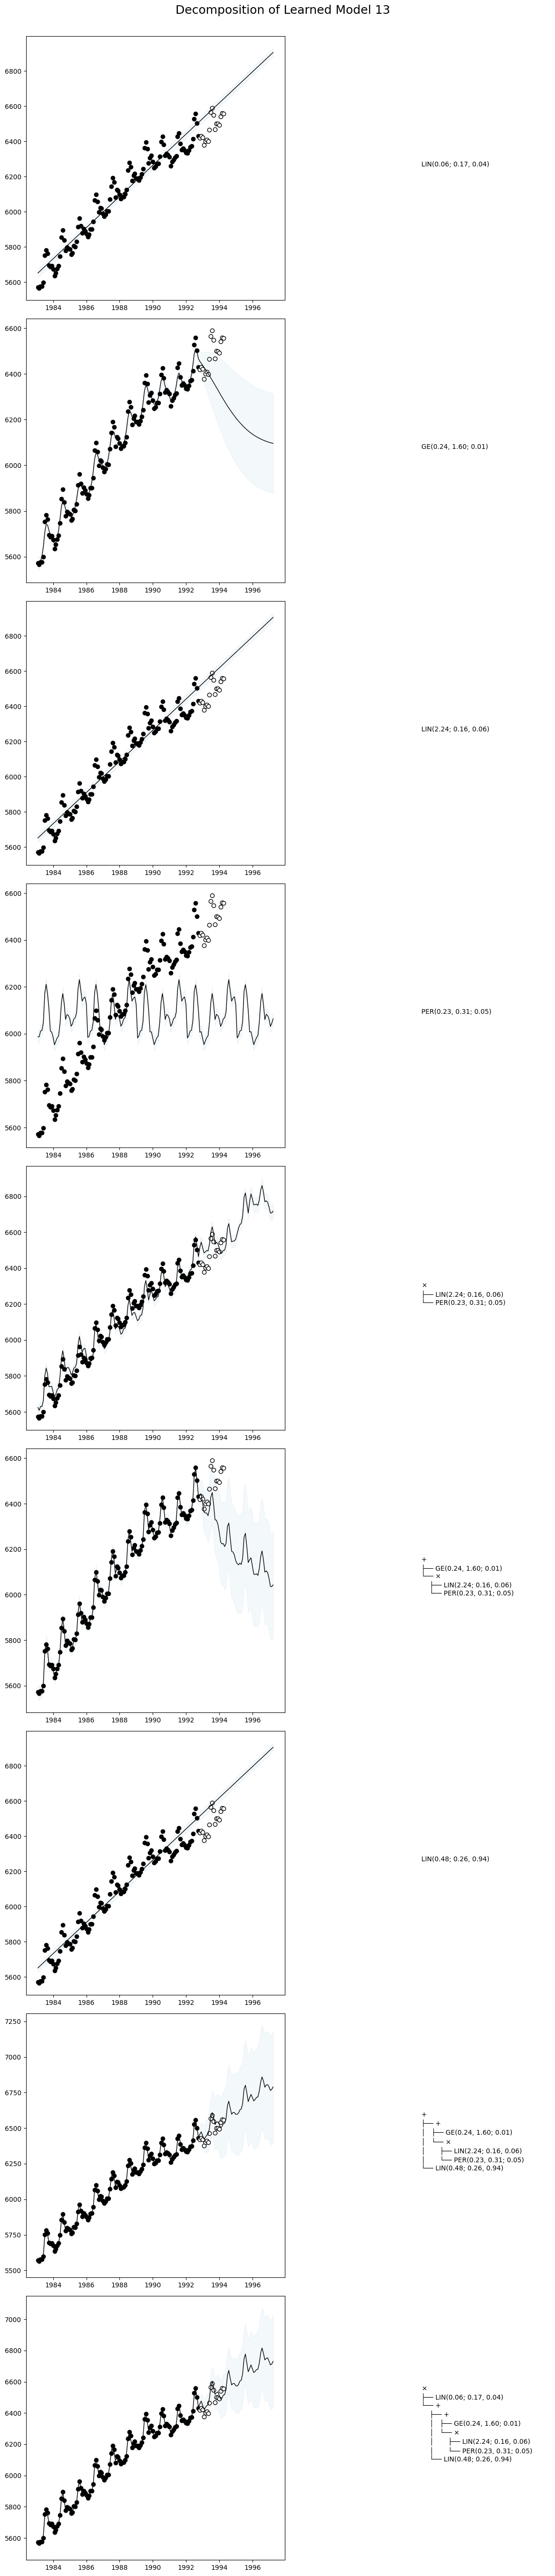

In [14]:
idx = 13
fig, ax = plot_decomposition(decomposed_models[idx]);
fig.suptitle("Decomposition of Learned Model $(idx)", fontsize=18, va="center", y=1);